# Linear programming for Water Distribution Systems - Optimization project (1/2)

Notebook based on paper: Ishwar Gupta

### ☑ <font color='#0096FF'>Blue-tape list<font><a class='anchor' id='top'></a>

<font color='#0096FF'>Blue-tape list<font><a class='anchor' id='top'></a>
Current:

Queue:
- Time the solution
- Explain function S. They are the coefficients that indicate how much the pressure energy decreases per meter of pipe. Call the attention that the coefficients S are static and linear once calculated.
- Linear programming or Gurobi brief explanation?
- Add questions to this solution. What happens if we change the cost of the pipes?
- Check that the numbers in the text and the code  match
- Rewrite some things for clarity
- Add specific instructions
- Check for typos and grammar
- Define more specific objectives
- Add the reference to the paper
- Describe what is head and the variables involved
- Define that they can use primal simplex or interior point method (how to do it)
- Wrap the story as large transmition systems to villages. 
- For this application, we will only consider systems feed by reservoirs that work via gravity.
- Making the system a gravity based system and mentioning the pump thing
- Explaining that we use meters instead of pascals thanks to the conversion.
- Explain it in terms of pressure losses

[Here I explain that the water needs energy to move from the reservoir to the consumption nodes and that the main energy consumption comes from the friction. In these systems, it is common to express the energy as normalized by weight and volume. This allows to work in units of meters, which tend to be easier to compare and visualise. Possible source (https://energyeducation.ca/encyclopedia/Hydraulic_head) ]

[Here I need to say how we consider the flow and the demand]

Done:
- Create function to calculate S
- Solve the exercise
- Connect the visualization of the 2D solution to the Gurobi answer
- Create figure 2. Make simple diagrams of the systems
- Improve the main image


**Objectives:**
- Implement a linear programming solution for the optimization of a water distribution system 

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Defining the optimization problem
  - Solving the optimization problem
  - Analyzing the optimization problem
- Answered all the questions

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- Gurobi

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp

## 🔙 Background

A water distribution system transports water from sources, like wells or reservoirs, to various locations where water is needed, like homes, shops, and factories. 

This kind of system consists of sources of water supply, pumping stations and demand points for water, all connected by pipe lines. In a city of moderate size, there may be a number of supply centers and thousands of demand points. For the sake of simplicity, we illustrate the optimization algorithms with a small system as example. Figure 1 shows a typical system where there are two supply centers, ten demand points, and two pumping stations.

<div>
<center><img src="../4x/WDSAsset 1v1.png" width="400"/></center>
</div>

<!-- ![WDSAsset 1v1.png](<attachment:WDSAsset 1v1.png>) -->

Figure 1. Simplified scheme of a branched water distribution system.
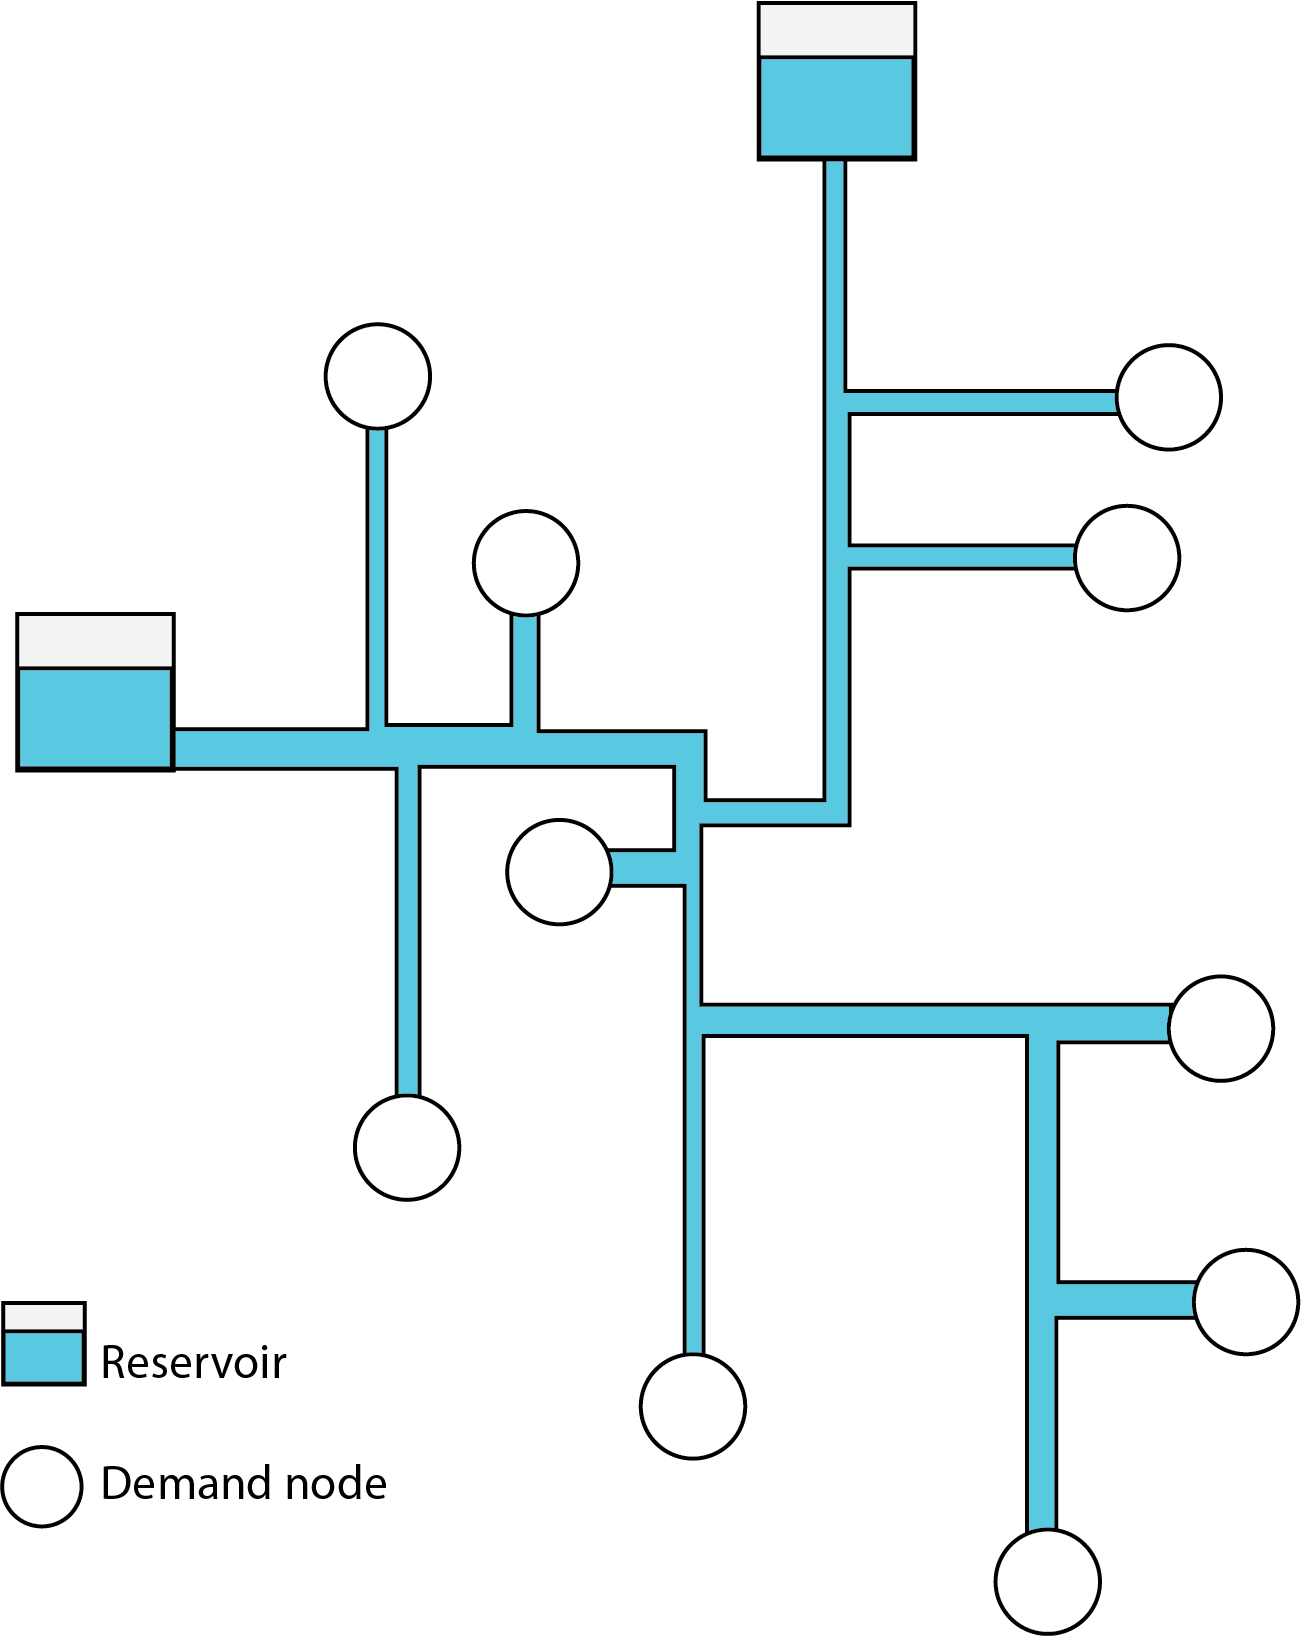

In a water distribution system, the energy that the water requires to move from a point to other is expressed as 

## ⛔ Problem definition 

The problem is to find the pipe lenghts and diameters that minimize the cost of the pipe lines while satisfying the customer demand for water usage and supply pressure. 

<!-- For this application, we will only consider systems feed by reservoirs that work via gravity. -->

To solve this problem, we can consider that the pipe lines can be composed of multiple segments. Each segment has one of the available diameters. In that case, a water distribution system with M pipes and N possible diameters will have $ M \cdot N $ decision variables. 
 
If we consider only two posibilities for diameters, one pipe line can be divided in two sections of lengths $L_{1}$ and $L_{2}$. If any of the lenghts is equal to the total length, that means that the pipe has only one diameter.

We can frame this problem in an optimization setting. To do so, we need to define the objective function and the restrictions. 

### 🎯 Objective function

We want to minimize the cost of the pipes. Each pipe has a different cost according to its diameter and its length. Generally, the larger the pipe, the more expensive it is. 

We can define the total cost $Z$ of installing all the pipes as the following function
$$
\begin{align}
  & min Z = \sum_{j=1}^{N}C_{j}\sum_{i=1}^{M} L_{ij}\\
\end{align}
$$ (eq_cost_function)

where $C_{j}$ is the cost of pipe per meter-length having diameter $j$.

### 🚫 Restrictions

We consider two main restrictions.

1) The water should arrive at the consumer nodes with sufficient pressure. This is, there should be sufficient energy for transporting the water from the source to each of nodes. This restriction can be written as

$$
\sum_{j=1}^{N}\sum_{i=1}^{M}S_{ijk} \cdot L_{ijk} \leq H_{k} \; \text{for every path k between the reservoir and a consumer node.}
$$

[Define S] where $S$ is a function of the 

2) The sum of all the sections in a pipe must be the total length of each pipe.

$$
\sum_{j=1}^{N}L_{ij} = L_{i} \; \text{  for each pipe  } i = 1, 2,..., M
$$


In addition, we consider that all lengths and heights are larger or equal than zero.
$$
L_{ij}\geq 0 \; \text{  for each segment} \; j \;\text{of each pipe  } i = 1, 2,..., M
$$
$$

## 💻 Linear Programming - Example

We exemplify the solution for a simple case shown in figure 2. This system consists of a reservoir located 180 meters above the consumption node, and it only has one pipe line of length $L$ = 3 km that delivers the water to a consumption node which demands a flow $q$ of 1.5 $m^{3}/s$. In addition, the water company should guarantee that the pressure at the consumption node is at least 20 m.c.a.

The available diameters and their cost-per-meter are given in the following table: 
| Diameter | Cost per meter [€/m]|
|----------|----------------|
| 0.3| 4.0|
| 0.4| 2.0|


<div>
<center><img src="../4x/WDSAsset 4v1.png" width="1200"/></center>
</div>

Figure 2. 

To solve this problem, let's create a model in Gurobi to see how it works. To create the model (based on what we have learned so far), you can do something like this:

In [2]:
def calculate_S(flow, diameter):
    # This function calculates the head loss per unit length of a steel pipe (roughness coefficient C = 100) in SI units.
    # Input: flow in cubic meters per second, diameter in meters.
    
    return (10.67/(100**1.852)) * (flow**1.852)/(diameter**4.8704)

In [3]:
total_length = 200
min_pressure = 180-20
available_diameters = np.array([0.3, 0.4])

coefficients_s = calculate_S(flow = 1.5, diameter=available_diameters)
coefficients_cost = np.array([2, 4])

In [4]:
coefficients_s

array([1.57367147, 0.3876256 ])

In [5]:
#Initialize a Gurobi model
model = gp.Model()

#Create decision variables
lengths = model.addVars(len(available_diameters), name="lengths")

#Set minimization objective
model.setObjective(gp.quicksum(coefficients_cost[i] * lengths[i] for i in range(len(lengths))), gp.GRB.MINIMIZE)

#Add constraints
#Length
model.addConstr(gp.quicksum(lengths[i]for i in range(len(lengths)))==total_length)

for i in range(len(lengths)):
    model.addConstr(lengths[i] >= 0)

#Pressure
model.addConstr(gp.quicksum(coefficients_s[i] * lengths[i] for i in range(len(lengths))) <= min_pressure)

model.update()


Restricted license - for non-production use only - expires 2024-10-28


In [6]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xb6791955
Coefficient statistics:
  Matrix range     [4e-01, 2e+00]
  Objective range  [2e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+02]
Presolve removed 4 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6092464e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.609246369e+02


In [7]:
print(model.display())

Minimize
  2.0 lengths[0] + 4.0 lengths[1]
Subject To
  R0: lengths[0] + lengths[1] = 200
  R1: lengths[0] >= 0
  R2: lengths[1] >= 0
  R3: 1.5736714732390413 lengths[0] + 0.3876255981684169 lengths[1] <= 160
None


In [8]:
optimal_lengths = model.x
optimal_cost = model.objVal

print(optimal_lengths)

[69.5376815516563, 130.4623184483437]


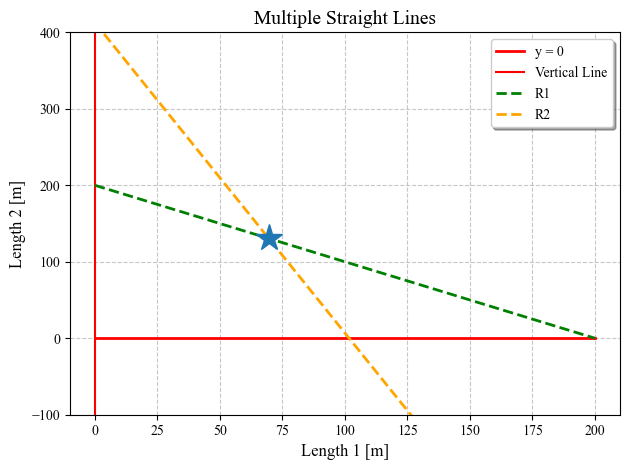

In [9]:
# Generate some data points for the lines
length_1 = np.linspace(0, total_length, 100)

x_axis = np.zeros_like(length_1)
y_axis = np.zeros_like(length_1)

length_2_restr_1 = total_length - length_1
length_2_restr_2 = (min_pressure - coefficients_s[0] * length_1) / coefficients_s[1]

# length_2_cost_function = (539 - coefficients_cost[0] * length_1) / coefficients_cost[1]

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the lines with different line styles and colors
ax.plot(length_1, x_axis, label='y = 0', color='red', linestyle='-', linewidth=2)
ax.axvline(x=y_axis[0], color='red', linestyle='-', label='Vertical Line')

ax.plot(length_1, length_2_restr_1, label='R1', color='green', linestyle='--', linewidth=2)
ax.plot(length_1, length_2_restr_2, label='R2', color='orange', linestyle='--', linewidth=2)

plt.plot([optimal_lengths[0]], [optimal_lengths[1]], marker='*', ls='none', ms=20)

# ax.plot(length_1, length_2_cost_function, label='Cost function', color='blue', linestyle=':', linewidth=2)

# Set labels and title with increased font size
ax.set_xlabel('Length 1 [m]', fontsize=12)
ax.set_ylabel('Length 2 [m]', fontsize=12)
ax.set_title('Multiple Straight Lines', fontsize=14)

# Add a legend with larger font size and shadow
ax.legend(fontsize=10, shadow=True)

# Set grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Customize tick label font size
ax.tick_params(axis='both', labelsize=10)

ax.set_ylim(-100, 400)

# Show the plot with a tight layout
plt.tight_layout()

# Show the plot
plt.show()



Another possibility is to use the matrix representation.

In [10]:
# coefficients_s.transpose()

In [11]:
# # initiate the model
# model_matrix = gp.Model()

# # Create variables
# lengths_m = model_matrix.addMVar(shape=np.shape(coefficients_s), name="lengths_m")

# # Set objective
# model_matrix.setObjective(coefficients_s.t() @ x, gp.GRB.MINIMIZE)

# # Add constraints
# model_matrix.addConstr(a @ x >= b, name="c")

# model_matrix.update()

Since there are two decision variables, it is possible to visualize the restrictions and the solution in a 2D plane.

Questions:
What happens if the restriction coefficients change?


## 💻 Linear Programming - Exercise

Consider the larger network in figure 3. This system consists of a reservoir that supplies to two consumer nodes. 
The reservoir is located at 130 meters above the reference level. The first pipe line connects the reservoir to a diversion node where the network splits in two branches: Pipe lines 2 and 3. 

Pipe line 1 has a length $L_{1}$ of 40 meters, pipe line 2 has a length $L_{2}$ of 10 meters, and pipe line 3 has a length $L_{3}$ of 20 meters. 

Node A demands 3 $m^{3}/s$ and node B demands 2 $m^{3}/s$.

Node A must have a hydraulic head of 30 m.c.a or more, and node B must have a hydraulic head of 30 m.c.a or more.

The available diameters and their cost-per-meter are given in the following table: 
| Diameter | Cost per meter  [€/m]|
|----------|----------------|
| 0.5| 10|
| 1.0| 20|
| 1.5| 30|


<div>
<center><img src="../4x/WDSAsset 5v1.png" width="1000"/></center>
</div>

Figure 3. Larger system

**Instructions**
Find the length and diameter of each section for all the pipe lines in the water distribution system that minimizes the cost of installing the system while supplying the required amount of water and pressure.

In the following cell, define the variables for solving this new problem.

In [12]:
total_length_1 = 4000
total_length_2 = 1000
total_length_3 = 2000

flow_1 = 5
flow_2 = 2
flow_3 = 3

min_pressure = 130-30
available_diameters = np.array([0.5, 1.0, 1.5])

coefficients_s_1 = calculate_S(flow = flow_1, diameter=available_diameters)
coefficients_s_2 = calculate_S(flow = flow_2, diameter=available_diameters)
coefficients_s_3 = calculate_S(flow = flow_3, diameter=available_diameters)

coefficients_cost = np.array([10, 20, 30])

In the following cell, define the Gurobi model, including the objective function and restrictions. 

In [13]:
#Initialize a Gurobi model
model = gp.Model()

#Create decision variables
lengths = model.addVars(len(available_diameters)*3, name="lengths")

#Set minimization objective
model.setObjective(gp.quicksum(coefficients_cost[i%3] * lengths[i] for i in range(len(lengths))), gp.GRB.MINIMIZE)

#Add constraints
#Length
model.addConstr(gp.quicksum(lengths[i]for i in [0, 1, 2])==total_length_1)
model.addConstr(gp.quicksum(lengths[i]for i in [3, 4, 5])==total_length_2)
model.addConstr(gp.quicksum(lengths[i]for i in [6, 7, 8])==total_length_3)

for i in range(len(lengths)):
    model.addConstr(lengths[i] >= 0)

#Pressure
model.addConstr(gp.quicksum(coefficients_s_1[i] * lengths[i] for i in [0,1,2]) + gp.quicksum(coefficients_s_2[i%3] * lengths[i] for i in [3,4,5]) <= min_pressure)
model.addConstr(gp.quicksum(coefficients_s_1[i] * lengths[i] for i in [0,1,2]) + gp.quicksum(coefficients_s_2[i%3] * lengths[i] for i in [6,7,8]) <= min_pressure)

model.update()


In [14]:
print(model.display())

Minimize
10.0 lengths[0] + 20.0 lengths[1] + 30.0 lengths[2] + 10.0 lengths[3]
+ 20.0 lengths[4] + 30.0 lengths[5] + 10.0 lengths[6] + 20.0 lengths[7] + 30.0 lengths[8]
Subject To
  R0: lengths[0] + lengths[1] + lengths[2] = 4000
  R1: lengths[3] + lengths[4] + lengths[5] = 1000
  R2: lengths[6] + lengths[7] + lengths[8] = 2000
  R3: lengths[0] >= 0
  R4: lengths[1] >= 0
  R5: lengths[2] >= 0
  R6: lengths[3] >= 0
  R7: lengths[4] >= 0
  R8: lengths[5] >= 0
  R9: lengths[6] >= 0
  R10: lengths[7] >= 0
  R11: lengths[8] >= 0
R12: 1.2156074648162658 lengths[0] + 0.04155821326773034 lengths[1] +
0.005767956804539288 lengths[2] + 0.22274525549582397 lengths[3] + 0.007615036185772089
 lengths[4] + 0.001056907800669166 lengths[5] <= 100
R13: 1.2156074648162658 lengths[0] + 0.04155821326773034 lengths[1] +
0.005767956804539288 lengths[2] + 0.22274525549582397 lengths[6] + 0.007615036185772089
 lengths[7] + 0.001056907800669166 lengths[8] <= 100
None


Optimize the model

In [15]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14 rows, 9 columns and 30 nonzeros
Model fingerprint: 0xb5683645
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 4e+03]
Presolve removed 10 rows and 2 columns
Presolve time: 0.01s
Presolved: 4 rows, 7 columns, 14 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2848433e+05   1.245535e+03   0.000000e+00      0s
       5    1.6240723e+05   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.624072286e+05


Print the results

In [16]:
model.x

[0.0,
 1723.8798071691062,
 2276.1201928308938,
 35.397333811095606,
 964.6026661889044,
 0.0,
 0.0,
 2000.0,
 0.0]

Questions about results interpretation. Comparison between Linear programming Simplex and interior point method. Call the attention to the execution time.